### Building an Agent-Based Question Answering System with LangGraph (RAG and LLM Fallback)

In [1]:
import os,openai
import pandas as pd
from typing import List, Tuple
from langchain_community.utilities import SQLDatabase
from langchain.chains import create_sql_query_chain
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter
from sqlalchemy import create_engine
from langchain_community.agent_toolkits import create_sql_agent
from langchain_openai import ChatOpenAI
import langchain
langchain.debug = False

import mysql.connector
from mysql.connector import pooling
from datetime import datetime  # Import datetime for timestamp handling
import logging
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Set the OpenAI API key
openai_api_key = os.getenv("OPENAI_API_KEY")

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

### Load Env variables

In [2]:
# Get the variables from the environment
load_dotenv(dotenv_path=".env.dbdetails")
db_user = os.getenv('DB_USER')
db_password = os.getenv('DB_PASSWORD')
db_host = "localhost"  ## Docker dbhost is not connecting via jupyter  
db_port = os.getenv('DB_PORT')
db_name = os.getenv('DB_NAME')

# Construct the MySQL URI
mysql_uri = f"mysql+mysqlconnector://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"

### Create SQL engine

In [3]:
# Define MySQL URI
engine = create_engine(mysql_uri)

# Create SQLDatabase object from URI
db = SQLDatabase.from_uri(mysql_uri)
print(db.dialect)

llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=1)
agent_executor = create_sql_agent(llm, db=db, agent_type="openai-tools",return_intermediate_steps=False, return_direct=True)

mysql


### Load the csv data into SQL DB

In [4]:
import glob

def prepare_data():
    # Define data folder path
    data_folder = '../data/'

    # Get list of CSV files starting with "CRYPTOCURRENCY"
    files = glob.glob(data_folder + 'CRYPTOCURRENCY*.csv')

    # Initialize empty list to store DataFrames
    dfs = []
    # Load each CSV file into a DataFrame and append to list
    for file in files:
        df = pd.read_csv(file)
        dfs.append(df)

    # Concatenate all DataFrames into a single DataFrame
    combined_df = pd.concat(dfs, ignore_index=True)
    combined_df = combined_df.rename(columns={
    'cryptocurrency': 'Symbol'
    }).astype({
    'Date': 'datetime64[ns]',
    'Symbol': 'object'
    })
    
    # Remove commas from columns and then convert to float
    combined_df['Open'] = pd.to_numeric(combined_df['Open'].replace(',', '', regex=True), errors='coerce')
    combined_df['Close'] = pd.to_numeric(combined_df['Close'].replace(',', '', regex=True), errors='coerce')
    combined_df['Low'] = pd.to_numeric(combined_df['Low'].replace(',', '', regex=True), errors='coerce')
    combined_df['High'] = pd.to_numeric(combined_df['High'].replace(',', '', regex=True), errors='coerce')

    print("\nCombined DataFrame shape:", combined_df.shape)
    return combined_df

def create_db_table(combined_df):
    # Create table in MySQL database
    combined_df.to_sql("crypto_data", engine, index=False, if_exists="replace")
    
    # Test if table is created
    try:
        result = pd.read_sql_table("crypto_data", engine)
        print("\nTable 'crypto_data' exists and has shape:", result.shape)
    except Exception as e:
        print("\nError:", str(e))
        
combined_df = prepare_data()
create_db_table(combined_df)


Combined DataFrame shape: (1464, 6)

Table 'crypto_data' exists and has shape: (1464, 6)


### Using an LLM to Create and Run SQL Queries for user question in plain text

In [5]:
chain = create_sql_query_chain(llm, db)
response = chain.invoke({"question": "How many unique symbol are there in crypto_data"})
print(response)
db.run(response)

2025-02-05 13:31:30,081 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


SELECT COUNT(DISTINCT `Symbol`) AS unique_symbols FROM crypto_data;


'[(4,)]'

In [6]:
try:
    chain = create_sql_query_chain(llm, db)
    question = "How many unique symbol are there in crypto_data"  # Or get this from user input
    response = chain.invoke({"question": question})
    print(response) # Print the query

    results = db.run(response)  # Capture the results
    print(results)  # Process and display the results

except Exception as e:
    logging.exception(f"An error occurred: {e}") # Log the full exception, including traceback
    print("An error occurred. Please check the logs for details.")  # User-friendly message

2025-02-05 13:31:31,449 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


SELECT COUNT(DISTINCT `Symbol`) AS UniqueSymbols FROM crypto_data
[(4,)]


### RAG Pipeline integration

#### Pass user question and create sql query with llm  and pass the sql query result to llm to generate meaningful answer

In [7]:
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser
#OutputParser that parses LLMResult into the top likely string.
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough

def get_answer_from_sql(user_query):
    answer_prompt = PromptTemplate.from_template(
        """Given the following user question,corresponding SQL query, and SQL result, 
        answer the user question in upto 4 lines from the data provided in the SQL result.
        If you have no answer, respond like you have no data.

        Question: {question}
        SQL Query: {query}
        SQL Result: {result}
        Answer: """
    )

    execute_query = QuerySQLDataBaseTool(db=db)
    write_query = create_sql_query_chain(llm, db)
    answer = answer_prompt | llm | StrOutputParser()

    chain = (
        RunnablePassthrough.assign(query=write_query).assign(
            result=itemgetter("query") | execute_query 
        )
        | answer_prompt
        | llm
        | StrOutputParser()
    )

    try:
        response = chain.invoke({"question": user_query})
        logging.info("Chain invoked successfully.")
        return response
    
    except OperationalError as e:
        logging.error(f"Database error: {e}", exc_info=True)  # Include stack trace
        return "There was a problem with the database. Please try again later." #Or a more generic message for security
    except KeyError as e:
        logging.error(f"Missing key in query result: {e}", exc_info=True)
        return "An internal error occurred. Please try again later."
    except LangChainError as e: #Example for Langchain errors
        logging.error(f"LLM error: {e}", exc_info=True)
        return "There was a problem with the language model. Please try again later."
    except Exception as e:  # Catch-all for unexpected errors
        logging.exception(f"An unexpected error occurred: {e}")  # logs the exception AND traceback
        return "An unexpected error occurred. Please try again later." #Or a more generic message for security


user_query = "what is the lowest price for ethereum in april"
response = get_answer_from_sql(user_query)
print(response)


C:\Users\padma\AppData\Local\Temp\ipykernel_162008\2131763530.py:19: LangChainDeprecationWarning: The class `QuerySQLDataBaseTool` was deprecated in LangChain 0.3.12 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-community package and should be used instead. To use it run `pip install -U :class:`~langchain-community` and import as `from :class:`~langchain_community.tools import QuerySQLDatabaseTool``.
  execute_query = QuerySQLDataBaseTool(db=db)
2025-02-05 13:31:34,198 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-05 13:31:34,845 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-05 13:31:34,848 - INFO - Chain invoked successfully.


The lowest price for Ethereum in April was $2864.54.


#### Using an LLM to Create and Run SQL Queries for user question in plain text

In [8]:
user_query = "which is cheap SOL or ETH overall"
response = get_answer_from_sql(user_query)
print(response)

2025-02-05 13:31:39,809 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-05 13:31:40,498 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-05 13:31:40,505 - INFO - Chain invoked successfully.


SOL is cheaper overall compared to ETH based on the provided minimum closing prices in the SQL result.


In [9]:
user_query = "Compare lowest price for dot with sol for april with date"
response = get_answer_from_sql(user_query)
print(response)

2025-02-05 13:31:43,141 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-05 13:31:44,155 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-05 13:31:44,161 - INFO - Chain invoked successfully.


The lowest price for DOT in April is $5.8121 on 2024-04-13. The lowest price for DOT in April is $5.8505 on 2024-04-14.


In [10]:
user_query = "which is cheap sol or dot overall"
get_answer_from_sql(user_query)

2025-02-05 13:31:45,041 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-05 13:31:45,700 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-05 13:31:45,706 - INFO - Chain invoked successfully.


'Based on the SQL result, DOT is cheaper overall compared to SOL.'

In [11]:
user_query = "which is the most expensive overall"
get_answer_from_sql(user_query)

2025-02-05 13:31:47,182 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-05 13:31:47,800 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-05 13:31:47,806 - INFO - Chain invoked successfully.


'BTC is the most expensive overall with a high price of 108309.0.'

### LangGraph Workflow: Agent Routing to RAG or LLM

In [12]:
#https://github.com/langchain-ai/langgraph/blob/main/docs/docs/tutorials/rag/langgraph_agentic_rag.ipynb
from langgraph.graph import Graph

from typing import TypedDict, Annotated, Sequence, Optional
import operator,re
from langchain_core.messages import BaseMessage

from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel , Field
from langchain.prompts import PromptTemplate


class TopicParser(BaseModel):
    Topic: str = Field(description='Selected Topic')

# Define AgentState with correct types and structure
class AgentState(TypedDict):
    user_question: str  # The original user question
    topic: Optional[str]  # The extracted topic (can be None initially)
    response: Optional[str] # The final response from either RAG or LLM
    messages: Annotated[Sequence[BaseMessage], operator.add] # For Langchain message history (if needed)

#### Nodes

In [28]:
TOPIC_LIST = ["BTC", "ETH", "SOL", "DOT"]

### Nodes
def agent(state: AgentState):
    print('-> Calling Agent ->')
    # Input validation
    if "user_question" not in state or not isinstance(state["user_question"], str):
        state["topic"] = "Error: Missing or invalid user question"
        return state
    
    question = state["user_question"]

    template = """ Your task is to provide ONLY the topic based on the user query, in *strict* valid JSON format. 

    Output ONLY a JSON object with a single key named "Topic". The value of "Topic" MUST be one of the following: {TOPIC_LIST}.  Do NOT include any other text, explanations, or backticks.  The JSON must be parsable by a standard JSON library.

    Examples:  <--- Few-shot examples
    User Query: What is the price of BTC?
    ```json
    {{
      "Topic": "BTC"
    }}
    ```
    User Query: Tell me about Ethereum.
    ```json
    {{
      "Topic": "ETH"
    }}
    ```
    User Query: Compare Solana and Ethereum.
    ```json
    {{
      "Topic": "Others"
    }}
    ```

    Following is the user query:  {question}
    """

    prompt = PromptTemplate(template=template, input_variables=["question"])
    chain = prompt | llm  

    response = chain.invoke({"question": question, "TOPIC_LIST": TOPIC_LIST})  

    if response:  # Check for None response
        response_text = response.content

        print(f"Raw LLM Response: {response_text}")
        print(repr(response_text))  # Keep this for debugging

        response_text = response_text.replace("```json", "").replace("```", "").strip()  # ***Remove the backticks***
        response_text = response_text.strip()  # Remove leading/trailing whitespace
        response_text = re.sub(r'[^\x00-\x7F]+', '', response_text)  # Remove non-ASCII

        try:
            # Try decoding with UTF-8, handling potential BOM
            response_text = response_text.encode('utf-8').decode('utf-8-sig')
            data = json.loads(response_text)
            topic = data.get("Topic")

            if topic in TOPIC_LIST:
                state["topic"] = topic
                return state
            else:  # Validation and Fallback (Crucial!)
                print(f"LLM returned invalid topic: {topic}. Using 'Others'.")  
                state["topic"] = "Others"  # Or handle differently
                return state

        except UnicodeDecodeError:
            try:
                data = json.loads(response_text)  
                topic = data.get("Topic")
                if topic in TOPIC_LIST:
                    state["topic"] = topic
                    return state
                else:
                    state["topic"] = "Error: Invalid topic received."  
                    return state
            except json.JSONDecodeError as e:
                print(f"JSON Decode Error: {e}")
                state["topic"] = "Error: Invalid JSON from LLM."
                return state

        except json.JSONDecodeError as e:
            print(f"JSON Decode Error: {e}")
            state["topic"] = "Error: Invalid JSON from LLM."
            return state

        except Exception as e:
            print(f"Unexpected Parsing Error: {e}")
            state["topic"] = "Error: Could not determine topic."
            return state

    else:
        print("Error: No response from LLM.")
        state["topic"] = "Error: No response from LLM."
        return state

    

def call_rag(state):
    print('-> Calling RAG ->')
    
    user_question = state["user_question"]
    try:
        result = get_answer_from_sql(user_question)
        state["response"] = result
    except Exception as e:
        state["response"] = f"Error in RAG: {e}"  
    return state


def call_llm(state):
    logging.info('-> Calling LLM ->')
    question = state["user_question"]
    
    try:
        complete_query = "Answer the following question with your knowledge of the real world: " + question
        response = llm.invoke(complete_query)
        
        # Response handling
        if not isinstance(response.content, str):
            state["response"] = "Error: Invalid LLM response"
            return state
        
        state["response"] = response.content
    except TimeoutError as e:
        state["response"] = f"Error: LLM timeout - {e}"
    except ConnectionError as e:
        state["response"] = f"Error: LLM connection error - {e}"
    except Exception as e:
        state["response"] = f"Error in LLM: {e}"
    
    logging.info('<- LLM call completed <-')
    return state
    


#### Router

In [29]:
def graph_router(state):
    print('-> Router ->')
    topic = state["topic"]
    if topic in TOPIC_LIST:
        return 'RAG Call'
    else:
        return 'LLM Call'
    
def manual_router(state):
    print('-> Manual Router ->')
    topic = state["topic"]
    if topic in TOPIC_LIST:  
        routing_decision = "RAG Call"
        state = call_rag(state)
    else:
        routing_decision = "LLM Call"
        state = call_llm(state)
    
    return state["response"]    
    
def query_AI_Agent_manual(query):
    state = {"user_question": query, "topic": None, "response": None}

    state = agent(state)
    routing_decision = manual_router(state)
    print(state["user_question"])
    print(routing_decision) # Print the final response.
    
query= "which is cheapest ethereum?"
print("Testing manual router ********")
query_AI_Agent_manual(query)
print()

Testing manual router ********
-> Calling Agent ->


2025-02-05 16:21:42,044 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Raw LLM Response: {
  "Topic": "ETH"
}
'{\n  "Topic": "ETH"\n}'
-> Manual Router ->
-> Calling RAG ->


2025-02-05 16:21:42,860 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-05 16:21:43,458 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-05 16:21:43,464 - INFO - Chain invoked successfully.


which is cheapest ethereum?
The cheapest Ethereum is priced at $2133.03.



#### Defining Graph for the workflow

In [30]:
from langgraph.graph import StateGraph,END

# Define a new graph
### StateGraph with AgentState
workflow = StateGraph(AgentState) 

# Define the nodes we will cycle between
workflow.add_node("agent", agent)
workflow.add_node("RAG", call_rag)
workflow.add_node("LLM", call_llm)

# entry point of the graph
workflow.set_entry_point("agent")

# conditional edges are controlled by our router
# Decide whether to call rag or llm directly
workflow.add_conditional_edges(
    "agent",  # entry point of the graph
    graph_router,  # function to determine which node is called
    {
        'RAG Call': "RAG",
        'LLM Call': "LLM",
    }
)

workflow.add_edge("RAG", END)
workflow.add_edge("LLM", END)

graph = workflow.compile()

#### Visualizing the graph

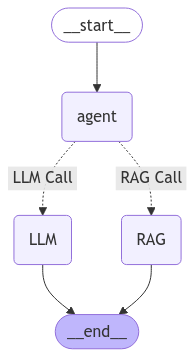

In [31]:
from IPython.display import Image,display

def display_graph(app_to_display):
    try:
        display(Image(app_to_display.get_graph().draw_mermaid_png()))
    except Exception as e:
        print(e)

display_graph(graph)

#### Langraph graph call example

In [32]:
def query_AI_Agent(query):
    initial_state: AgentState = {
        "user_question": query,  
        "topic": None,
        "response": None,
        "messages": []
    }
    try:
        final_state = graph.invoke(initial_state)
        response = final_state["response"]
        return response
        
    except Exception as e:
        # Show any errors that occur during the API call
        st.error(f"Error: {e}")
        return None

query = "which is cheapest ethereum"
print("Testing graph router  ********")
query_AI_Agent(query)

Testing graph router  ********
-> Calling Agent ->


2025-02-05 16:21:56,089 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Raw LLM Response: ```json
{
  "Topic": "ETH"
}
```
'```json\n{\n  "Topic": "ETH"\n}\n```'
-> Router ->
-> Calling RAG ->


2025-02-05 16:21:56,992 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-05 16:21:57,781 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-05 16:21:57,787 - INFO - Chain invoked successfully.


'The cheapest Ethereum price was $2133.03 on August 5, 2024.'

In [24]:
query = "which is the most expensive ETH or BTC"
query_AI_Agent(query)

-> Calling Agent ->


2025-02-05 13:32:55,677 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Raw LLM Response: {
	"Topic": "ETH"
}
'{\n\t"Topic": "ETH"\n}'
-> Router ->
-> Calling RAG ->


2025-02-05 13:32:56,664 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-05 13:32:57,478 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-05 13:32:57,486 - INFO - Chain invoked successfully.


'BTC is the most expensive cryptocurrency with a high value of 108309.'

In [20]:
query = "which is cryptocurrency"
query_AI_Agent(query)

-> Calling Agent ->


2025-02-05 13:32:19,853 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Raw LLM Response: ```json
{
  "Topic": "Others"
}
```
'```json\n{\n  "Topic": "Others"\n}\n```'
LLM returned invalid topic: Others. Using 'Others'.
-> Router ->
-> Calling LLM ->


2025-02-05 13:32:21,588 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


'Cryptocurrency is a type of digital or virtual currency that uses cryptography for security and is decentralized, meaning it is not issued by any central authority like a government or financial institution. Examples of cryptocurrencies include Bitcoin, Ethereum, and Litecoin. Cryptocurrencies can be used for various online transactions and investments.'

In [21]:
query = "which is cheaper SOL or ETH"
query_AI_Agent(query)

-> Calling Agent ->


2025-02-05 13:32:22,481 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Raw LLM Response: ```json
{
  "Topic": "SOL"
}
```
'```json\n{\n  "Topic": "SOL"\n}\n```'
-> Router ->
-> Calling RAG ->


2025-02-05 13:32:23,437 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-05 13:32:24,375 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-05 13:32:24,385 - INFO - Chain invoked successfully.


'Based on the SQL result, SOL is cheaper than ETH as the closing price of SOL on January 23, 2024, is 81.06 compared to ETH which is not included in the result data.'